<a href="https://www.kaggle.com/code/lestiessam/ag-news-classification?scriptVersionId=240902360" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import string
import nltk
import re
import string as s

from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from nltk.tokenize import word_tokenize, sent_tokenize

from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-05-20 21:59:45.748770: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747778385.930862      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747778385.985217      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/ag-news-classification-dataset/train.csv
/kaggle/input/ag-news-classification-dataset/test.csv


In [2]:
# load the train and test dataset
train_data = pd.read_csv('/kaggle/input/ag-news-classification-dataset/train.csv', header=0, names=['ID','Title','Desc'])
test_data = pd.read_csv('/kaggle/input/ag-news-classification-dataset/test.csv', header=0, names=['ID','Title','Desc'])

# Add the train_data and test_data together
df = pd.concat([train_data, test_data])
df.shape, train_data.shape, test_data.shape

((127600, 3), (120000, 3), (7600, 3))

In [3]:
df.head()

,ID,Title,Desc
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [4]:
df['Title'][2]

2    Oil and Economy Cloud Stocks' Outlook (Reuters)
2      Ky. Company Wins Grant to Study Peptides (AP)
Name: Title, dtype: object

In [5]:
df['Desc'][2]

2    Reuters - Soaring crude prices plus worries\ab...
2    AP - A company founded by a chemistry research...
Name: Desc, dtype: object

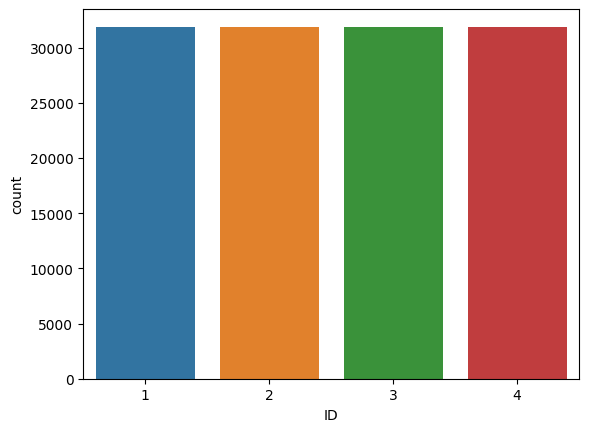

In [6]:
# create a countplot for ID
sns.countplot(x='ID', data=df)
plt.show()

In [7]:
# Rename the Desc column
df['clean_Desc'] = df['Desc']

In [8]:
def remove_html_tag(text):
    html = re.compile('<.*?')
    cleaned_text = html.sub('', text)
    return cleaned_text

df['clean_Desc']=df['clean_Desc'].apply(lambda x: remove_html_tag(x))

def url_remove(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r'',text)

df['clean_Desc'] = df['clean_Desc'].apply(lambda x: url_remove(x))
StopWords = stopwords.words("english")
def remove_stopwords(text):
    filtered_text = ' '.join(word for word in text.split() if word.lower() not in StopWords)
    return filtered_text

df['clean_Desc'] = df['clean_Desc'].apply(lambda x: remove_stopwords(x))
def remove_punctuation(text):
    punc = string.punctuation
    return text.translate(str.maketrans('', '',punc))

df['clean_Desc'] = df['clean_Desc'].apply(lambda x: remove_punctuation(x))

In [9]:
df.head()

,ID,Title,Desc,clean_Desc
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Reuters Shortsellers Wall Streets dwindlingba...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Reuters Private investment firm Carlyle Group...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Reuters Soaring crude prices plus worriesabou...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Reuters Authorities halted oil exportflows ma...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",AFP Tearaway world oil prices toppling record...


In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['clean_Desc'], df['ID'], test_size=0.2, random_state=42)

In [11]:
# Tokenize and pad sequences
max_features = 20000 # Vocabulary size
maxlen = 100 # Max sequence length

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)

x_train_seq = pad_sequences(tokenizer.texts_to_sequences(x_train), maxlen=maxlen)
x_test_seq = pad_sequences(tokenizer.texts_to_sequences(x_test), maxlen=maxlen)

In [12]:
from sklearn.preprocessing import LabelEncoder

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [13]:
# Check for labels in y_train and y_test
print("Unique labels in y_train:", np.unique(y_train))
print("Unique labels in y_test:",np.unique(y_test))

Unique labels in y_train: [0 1 2 3]
Unique labels in y_test: [0 1 2 3]


In [14]:
print("First padded training sequences:", x_train[0])
print("First padded training sequences:", x_test[0])

First padded training sequences: Unions representing workers Turner Newall say disappointed talks stricken parent firm Federal Mogul
First padded training sequences: Reuters  Shortsellers Wall Streets dwindlingband ultracynics seeing green again


In [15]:
# Build the RNN model
model = Sequential([
    Embedding(input_dim=max_features, output_dim=50, input_length=maxlen),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(4, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1747778412.658068      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [16]:
checkpoint = EarlyStopping(monitor='val_accuracy', patience=10, mode='max')
callbacks_lst = [checkpoint]

In [17]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

callbacks_lst = [checkpoint]
#Training
batch_size= 256
epochs =  100
print('Train...')

# Train the model
history = model.fit(
    x_train_seq, y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks_lst
)

Train...
Epoch 1/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 208s 157ms/step - accuracy: 0.7557 - loss: 0.6133 - val_accuracy: 0.8994 - val_loss: 0.3019
Epoch 2/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 200s 157ms/step - accuracy: 0.9289 - loss: 0.2189 - val_accuracy: 0.9058 - val_loss: 0.2863
Epoch 3/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 200s 156ms/step - accuracy: 0.9462 - loss: 0.1633 - val_accuracy: 0.9009 - val_loss: 0.3062
Epoch 4/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 200s 157ms/step - accuracy: 0.9570 - loss: 0.1285 - val_accuracy: 0.8971 - val_loss: 0.3286
Epoch 5/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 200s 156ms/step - accuracy: 0.9653 - loss: 0.1019 - val_accuracy: 0.8938 - val_loss: 0.3722


In [18]:
print('continue')

continue


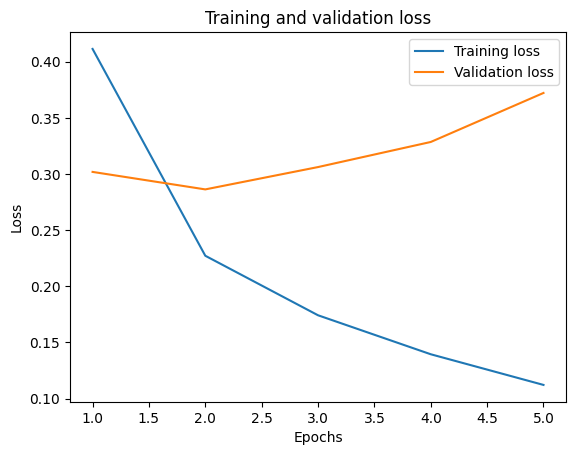

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# 'bo' is for "blue dot"
plt.plot(epochs, loss, label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

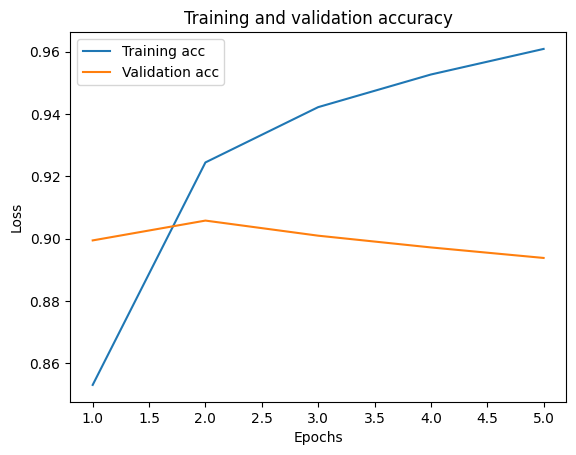

In [20]:
plt.clf() # clear figure
acc_values = history.history['accuracy']
val_acc_values = history.history['val_accuracy']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [21]:
#Evaluate the model
test_loss, test_acc = model.evaluate(x_test_seq, y_test)
print(f"Test Accuracy: {test_acc}")

# Predict on new data
sample_text = ["Breaking news in technology and science"]
sample_seq = pad_sequences(tokenizer.texts_to_sequences(sample_text), maxlen=maxlen)
prediction = model.predict(sample_seq)
print(f'Predicted Class: {np.argmax(prediction)}')

798/798 ━━━━━━━━━━━━━━━━━━━━ 39s 48ms/step - accuracy: 0.8955 - loss: 0.3648
Test Accuracy: 0.894670844078064
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
Predicted Class: 3


In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(x_test_seq).argmax(axis=-1)
report = classification_report(y_test, y_pred)
print(report)

798/798 ━━━━━━━━━━━━━━━━━━━━ 37s 46ms/step
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      6283
           1       0.93      0.97      0.95      6466
           2       0.88      0.85      0.86      6370
           3       0.85      0.89      0.87      6401

    accuracy                           0.89     25520
   macro avg       0.89      0.89      0.89     25520
weighted avg       0.89      0.89      0.89     25520



In [23]:
# Build the RNN model
model = Sequential([
    Embedding(input_dim=max_features, output_dim=50, input_length=maxlen),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(4, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [24]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Model definition
model = Sequential()
model.add(Embedding(1000, 50, input_length=maxlen))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(1024))
model.add(BatchNormalization())  # Add BatchNormalization
model.add(Dropout(0.25))
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Callbacks for better training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-5, verbose=1)

# Training the model
history = model.fit(
    x_train_seq, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


I0000 00:00:1747779512.636495      58 cuda_dnn.cc:529] Loaded cuDNN version 90300


2552/2552 ━━━━━━━━━━━━━━━━━━━━ 91s 32ms/step - accuracy: 0.7577 - loss: 0.6850 - val_accuracy: 0.7886 - val_loss: 0.5635 - learning_rate: 0.0010
Epoch 2/30
2552/2552 ━━━━━━━━━━━━━━━━━━━━ 81s 32ms/step - accuracy: 0.8369 - loss: 0.4580 - val_accuracy: 0.8044 - val_loss: 0.5443 - learning_rate: 0.0010
Epoch 3/30
2552/2552 ━━━━━━━━━━━━━━━━━━━━ 81s 32ms/step - accuracy: 0.8502 - loss: 0.4240 - val_accuracy: 0.8531 - val_loss: 0.4050 - learning_rate: 0.0010
Epoch 4/30
2552/2552 ━━━━━━━━━━━━━━━━━━━━ 81s 32ms/step - accuracy: 0.8551 - loss: 0.3999 - val_accuracy: 0.8497 - val_loss: 0.4167 - learning_rate: 0.0010
Epoch 5/30
2552/2552 ━━━━━━━━━━━━━━━━━━━━ 82s 32ms/step - accuracy: 0.8667 - loss: 0.3752 - val_accuracy: 0.8560 - val_loss: 0.3970 - learning_rate: 0.0010
Epoch 6/30
2552/2552 ━━━━━━━━━━━━━━━━━━━━ 82s 32ms/step - accuracy: 0.8736 - loss: 0.3574 - val_accuracy: 0.8569 - val_loss: 0.3968 - learning_rate: 0.0010
Epoch 7/30
2552/2552 ━━━━━━━━━━━━━━━━━━━━ 82s 32ms/step - accuracy: 0.8792 

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(x_test_seq).argmax(axis=-1)
report = classification_report(y_test, y_pred)
print(report)

798/798 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      6283
           1       0.94      0.92      0.93      6466
           2       0.82      0.84      0.83      6370
           3       0.81      0.82      0.82      6401

    accuracy                           0.86     25520
   macro avg       0.86      0.86      0.86     25520
weighted avg       0.86      0.86      0.86     25520



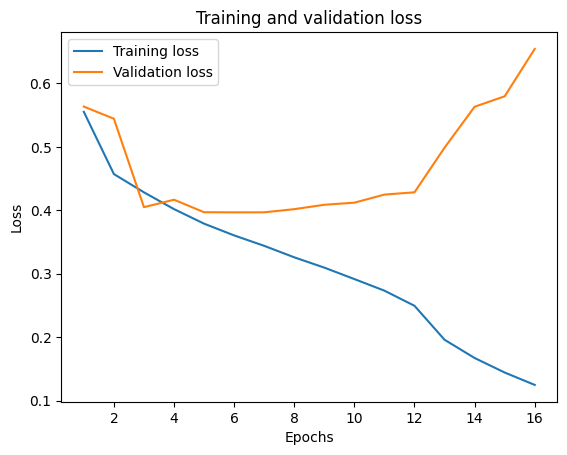

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# 'bo' is for 'blue dot'
plt.plot(epochs, loss, label='Training loss')
# b is for 'solid blue line'
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

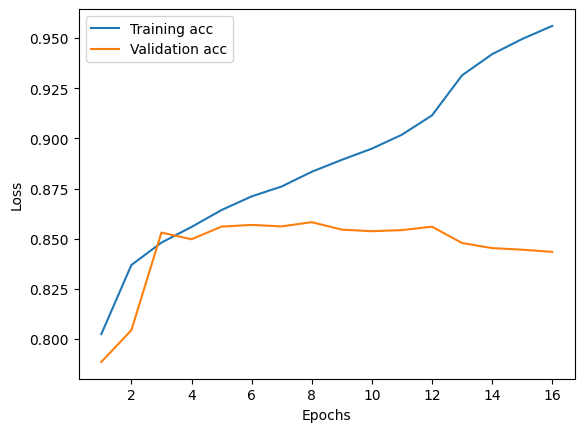

In [27]:
plt.clf() # clear figure
acc_values = history.history['accuracy']
val_acc_values = history.history['val_accuracy']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()